# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification Challenge

The task involves developing a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset provided contains 43,943 tweets collected between April 27, 2015, and February 21, 2018. Each tweet is labeled with one of four classes: News, Pro, Neutral, or Anti, representing different perspectives on climate change.
Your company has been awarded the contract to:

 1. Analyse the supplied data;
 2. Clean and transform data, including removing noise, handling missing values, and applying text preprocessing techniques like tokenization, stop-word removal, and stemming or lemmatization;
 3. Extract relevant features from the tweet data that can contribute to the classification task;
 4. Choose an appropriate Machine Learning algorithm for the classification task;
 5. Train the model and evaluate using appropriate evaluation metrics such as accuracy, precision, recall, and F1 score;
 6. Deploy to classify new, unseen tweets into the belief classes, and
 7. Explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model this classification problem, by exploring and preprocessing the data, perform feature engineering, and train a suitable Machine Learning model. The model will learn from the labeled tweets to classify new, unseen tweets into one of the belief classes accurately. The goal is to create a robust and accurate model that can provide valuable insights into people's perceptions of climate change.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents
<a href=#one>1. Introduction</a>

<a href=#two>2. Problem Statement</a>

<a href=#three>3. Importing Packages</a>

<a href=#four>4. Loading Data</a>

<a href=#five>5. Exploratory Data Analysis (EDA)</a>

<a href=#six>6. Data Engineering</a>

<a href=#seven>7. Modeling</a>

<a href=#eight>8. Model Performance</a>

<a href=#nine>9. Model Explanations</a>

<a href=#ten>10. Conclusion</a>

<a href=#eleven>11. References</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In today's world, climate change is a pressing global issue that has gained significant attention. Many companies are dedicated to reducing environmental impact and carbon footprints by offering sustainable and environmentally friendly products and services. To gauge public sentiment and understand how their offerings may be received, these companies require insights into people's beliefs regarding climate change.


 <a id="two"></a>
## 2. Problem Statement
<a href=#cont>Back to Table of Contents</a>

Develop a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset includes 43,943 tweets collected between April 27, 2015, and February 21, 2018, labeled with four classes:

- News: The tweet links to factual news about climate change.
- Pro: The tweet supports the belief of man-made climate change.
- Neutral: The tweet neither supports nor refutes the belief of man-made climate change.
- Anti: The tweet does not believe in man-made climate change.

The objective is to create an accurate and robust model that can provide insights into public sentiment on climate change, aiding companies in understanding the reception of their environmentally friendly products and services for informed marketing strategies.

 <a id="three"></a>
## 3. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [53]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re

# Libraries for data preparation and model building
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
import time
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib
# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###
# set plot style
sns.set()

<a id="four"></a>
## 4. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [54]:
# load the data
train = pd.read_csv('../resources/data/train.csv')
test = pd.read_csv('../resources/data/test_with_no_labels.csv')

<a id="five"></a>
## 5. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


**Checking the shape of the training and testing data:** The training set have three features and the testing set has two features. The Training set has 15819 observations and the testing set has 10546 Observations

In [55]:
#Training data
print(train.shape)
#Testing data
print(test.shape)

(15819, 3)
(10546, 2)


**Reading the first five rows of the training data:** As elaborated by the shape, the testing dataframe have three features namely the message, sentiment and the tweetid. 

In [81]:
# Reading the first 5 rows of test data
train.head()


,sentiment,tweetid,num_sentences,num_words,num_characters,updated message
0,1,625221,2,27,140,polyscimajor epa chief think carbon dioxide ma...
1,1,126103,1,11,62,like lack evidence anthropogenic global warming
2,2,698562,1,27,140,rt rawstory researchers say three years act cl...
3,1,573736,1,19,99,todayinmaker wired 2016 pivotal year war clim...
4,1,466954,2,26,122,rt soynoviodetodas 2016 racist sexist climate ...


**Reading the first five rows of the testing data:** As elaborated by the shape, the testing dataframe have two features namely the message and the tweetid. 

In [57]:
# Reading the first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


**DataFrame Information**

In [79]:
print('Checking for the datatypes, null values')
print('')
# Checking for the datatypes, null values
print(train.info())

print('')
print("Checking the sum of null values")
print('')
#Checking the sum of null values
print(train.isnull().sum())

Checking for the datatypes, null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        15819 non-null  int64 
 1   tweetid          15819 non-null  int64 
 2   num_sentences    15819 non-null  int64 
 3   num_words        15819 non-null  int64 
 4   num_characters   15819 non-null  int64 
 5   updated message  15819 non-null  object
dtypes: int64(5), object(1)
memory usage: 741.6+ KB
None

#Checking the sum of null values

sentiment          0
tweetid            0
num_sentences      0
num_words          0
num_characters     0
updated message    0
dtype: int64


**Observations:**

- By checking the infomation of the train set, it is confirmed that there are 15819 rows and 3 columns.
- It is also observed that there are no null values present in all the columns.
- Columns sentiment and tweetid contain numerical values, their dtype is int64. The message column contains non-numerical values, therefore it had a dtype object.
- Moreover, the dataframe takes up the space of 721.6 kb. 

In [60]:
def seperate_sent(sent_list):
    sentiments_dict = {}
    for num in sent_list:
        if num in sentiments_dict:
            sentiments_dict[num] += 1
        else:
             sentiments_dict[num] = 1
    return  sentiments_dict  

seperate_sent(train['sentiment'])

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

**Distribution of the Tweets over Four Sentiments**

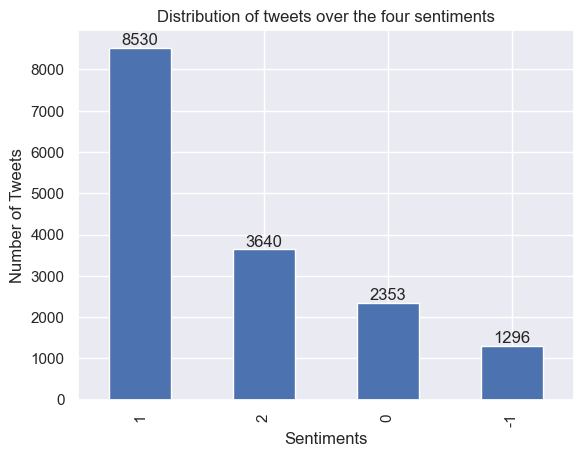

In [61]:
# Counting Number of words
train['sentiment'].value_counts().plot(kind = 'bar')

sentiments = list(seperate_sent(train['sentiment']).keys())
numbers = list(seperate_sent(train['sentiment']).values())

for i, value in enumerate(numbers):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.title('Distribution of tweets over the four sentiments')
plt.show()

**Observations:**

1. There are 8530 tweets for sentiment 1, 3640 tweets for sentiment 2, 2353 tweets for sentiment 0 and 1296 tweets for sentiment -1. 
2. There is data imbalance, those who supports man-made climate change make up half of all the tweets and those who are against the matter makes up only 8% of the entire tweets. 
3. There are many tweets from those who believe in man-made Climate change because those supports man made climate change are well versed about the matter and also, they easily share their views because they are more interested in the matter.
4. However, those who are against the notion may be skeptical due to personal beliefs which can lead to a reluctance to engage in discussions about man-made climate change. Also, those who do not believe in the matter may not have enough information to support their stance. 
5. The data imbalanced can be solved by resampling in order to improve Model Performance, Address Data Skewness, Preserve Information and mitigate Model Bias.

**Distribution of the number of characters on each tweets for the four sentiments**

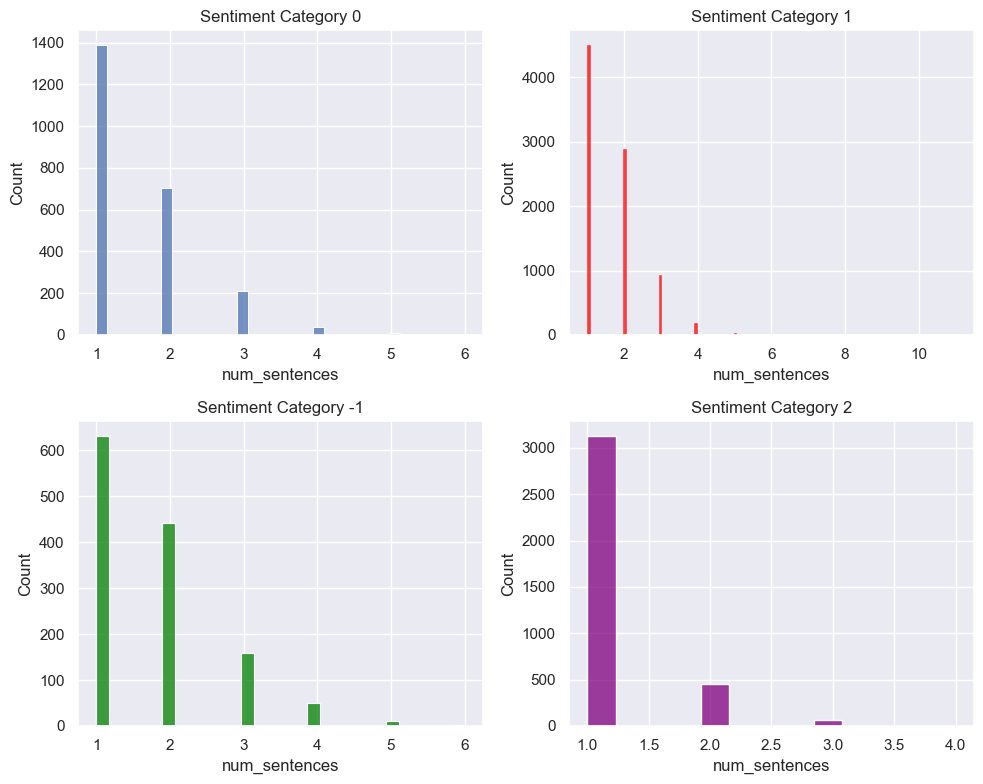

In [62]:
#Create a number of Sentences features
train['num_sentences'] = train['message'].apply(lambda x:len(nltk.sent_tokenize(x)))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_sentences'], ax=axes[0, 0])

# Plot histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_sentences'], color='red', ax=axes[0, 1])

# Plot histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_sentences'], color='green', ax=axes[1, 0])

# Plot histogram for sentiment category -2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_sentences'], color='purple', ax=axes[1, 1])

# Set the title for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

**Observation:** 

1. The news have a range of 1 to 4 number of sentences. Those who are neutral and those who are against the matter have a range of 1 to 6 sentences. However, those whose who supports man-made climate has a range of 1 to 11 sentences.
2. Those who supports the matters have outliers who might have a deeper understanding of the topic due to personal experiences, research, or education. Consequently, they may feel more confident and knowledgeable, resulting in more extensive and well-articulated responses.

**Distribution of the Number of Words on each tweets**

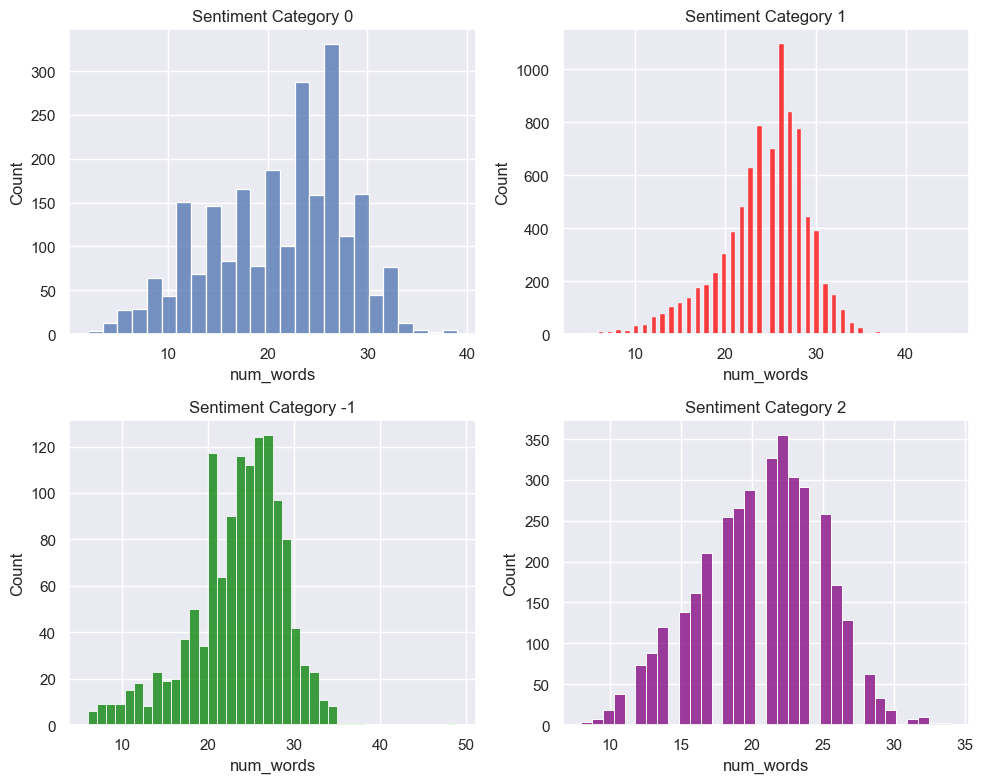

In [63]:
#Creating a number of Words feature
train['num_words'] =train['message'].apply(lambda x:len(nltk.word_tokenize(x)))

# A2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_words'], ax=axes[0, 0])

# Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_words'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_words'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_words'], color='purple', ax=axes[1, 1])

#Titles for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

**Observation:** 

1. The word count of the news range from 8 to 34 words, With the frequent words count of 22 words per tweet. The word count for those who are neutral range from 2 to 39 words, with the frequent words count of 26 words per tweet.The word count of who are against man made climate change range from 6 to 49 words, with the frequent word counts of 27 words per tweet. The word count of those who supports man made climate change range from 4 to 45 words, with frequent word count of 26 words per tweet.

2. Those who are supports man-made climate change and those who are against climate change have wide range of word counts compared to the neutral and News sentiment. Those individuals have strong emotions and beliefs associated with it. They felt compelled to express their opinions, arguments, and concerns in more detail, resulting in the use of many words. They felt a greater need to persuade others or defend their position, leading them to provide more extensive justifications and evidence to support their viewpoint.   This is beacause People who are against or support the  matter often face resistance and criticism. In response, they might employ more words to address potential counterarguments, clarify their stance, or counter opposing viewpoints.

*Need attention for revision*


**Distribution of the Number of Characters on each tweets**

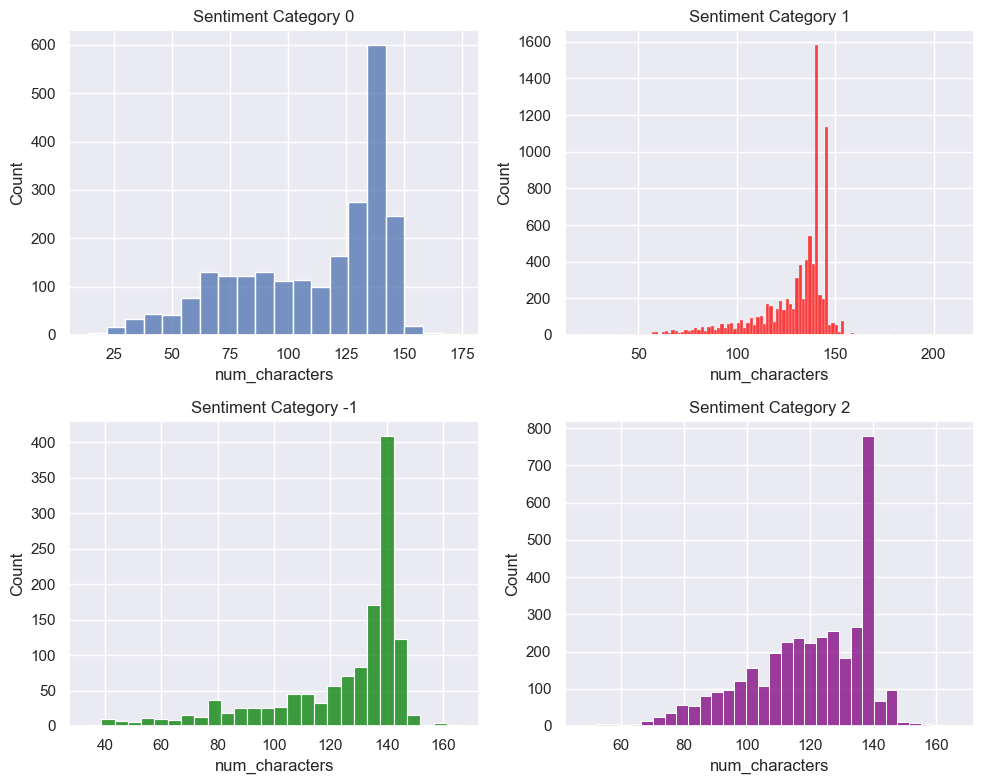

In [64]:
#Creating a number of characters feature
train['num_characters'] = train['message'].apply(len)

#A 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

#Histogram for sentiment category 0
sns.histplot(train[train['sentiment'] == 0]['num_characters'], ax=axes[0, 0])

#Histogram for sentiment category 1 (with a different color)
sns.histplot(train[train['sentiment'] == 1]['num_characters'], color='red', ax=axes[0, 1])

#Histogram for sentiment category -1 (with a different color)
sns.histplot(train[train['sentiment'] == -1]['num_characters'], color='green', ax=axes[1, 0])

#Histogram for sentiment category 2 (with a different color)
sns.histplot(train[train['sentiment'] == 2]['num_characters'], color='purple', ax=axes[1, 1])

#The title for each subplot
axes[0, 0].set_title('Sentiment Category 0')
axes[0, 1].set_title('Sentiment Category 1')
axes[1, 0].set_title('Sentiment Category -1')
axes[1, 1].set_title('Sentiment Category 2')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

**Observation:** 

1. All the sentement has a mode of 140 characters. Research has shown that initially twitter had a strict limit of 140 characters per tweet. Thus, this was one of the constraints which might have led to most individuals writing tweets with 140 chracaters though they wanted to write even more words. 
2. However, the constraints was later increased to 280, this has enable some individuals to fit their thoughts since the graphs above show no indication of a tweet with more than 280 characters. 

**Removing Stopwords**

In [66]:
nltk.download(['punkt','stopwords'])

#A function of removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)
#Removing stop words from training data
train['updated message'] = train['message'].apply(remove_stopwords)

**Removing punctuation Marks**

In [68]:
#A fucntion of removing puntuationa marks
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

# Create and Check if a new column contains messages with no punctuations
train['updated message'] = train['updated message'].apply(remove_punctuation).str.lower() #Words converted to lower case
train['updated message'].iloc[0]


**Masking the four sentiments**

In [70]:
#Tweets of those who believe in Climate change
pro = train.loc[train['sentiment'] == 1, 'updated message']
#Tweets of those dont believe in climate change
anti = train.loc[train['sentiment'] == -1, 'updated message']
#Tweets of those are neautral about climate change
neutral = train.loc[train['sentiment'] == 0, 'updated message']
##Tweets of the news
news = train.loc[train['sentiment'] == 2, 'updated message']

**Word Clouds of the top fifty Words that appear the most from each sentiment**

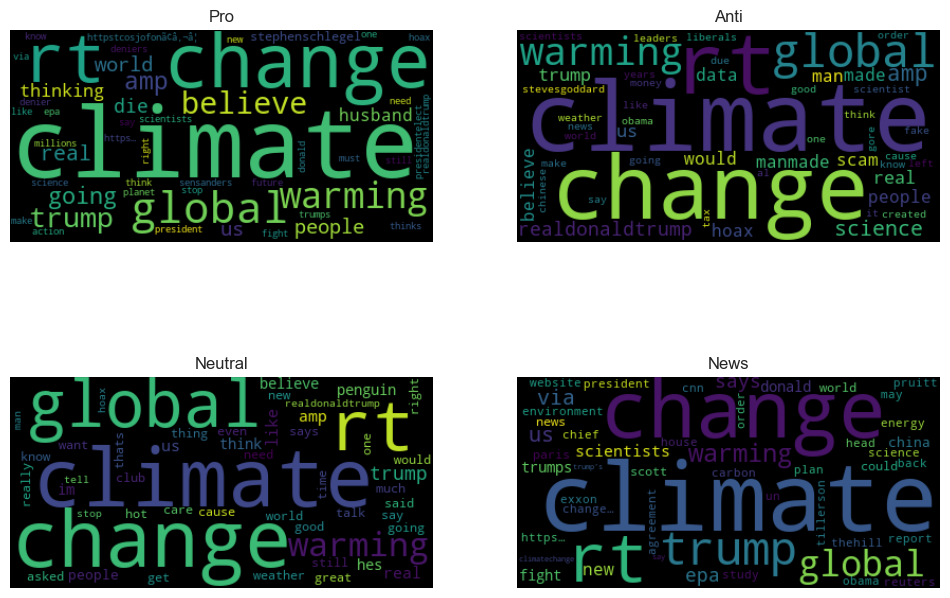

In [71]:
# Define the categories and their respective texts
categories = ['Pro', 'Anti', 'Neutral', 'News']
texts = [pro, anti, neutral, news]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
fig.subplots_adjust(hspace=0)  # Adjust the hspace parameter to remove vertical spacing

# Generate word clouds for each category and plot them
for i, ax in enumerate(axs.flat):
    # Calculate word distribution
    text = ' '.join(texts[i])
    words = text.split()
    word_counts = Counter(words)
    
    # Generate word cloud
    wordcloud = WordCloud(max_words=50)
    wordcloud.generate_from_frequencies(word_counts)
    
    # Plot the word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(categories[i])

# Show the subplots
plt.show()

## Observations:

1. From the cloud words above, it is observed that climate, change, global and warming are the most popular words that are used by individuals, this is expected since the topic revolves around these words.  
2. Those who support the matter use the word believe more than those who don't against the matter. Also, they also use the word going and die which doesnt appear on the word cloud of those against climate change.
3. People who are against the man-made Climate change use words like Fake and scam to show their resistance in the man made climate change. Moreover, they use hoax more often than those who support man-made climate change. 

**Ayanda**

<a id="six"></a>
## 6. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

**Palesa**

**Shibu**

**Lebo**

In [72]:
# View the data after EDA
train.head()

,sentiment,message,tweetid,num_sentences,num_words,num_characters,updated message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,2,27,140,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,1,11,62,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,1,27,140,rt rawstory researchers say three years act cl...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1,19,99,todayinmaker wired 2016 pivotal year war clim...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,2,26,122,rt soynoviodetodas 2016 racist sexist climate ...


In [73]:
# remove missing values/ features
# Remove the column message
train = train.drop('message', axis = 1)
train

,sentiment,tweetid,num_sentences,num_words,num_characters,updated message
0,1,625221,2,27,140,polyscimajor epa chief think carbon dioxide ma...
1,1,126103,1,11,62,like lack evidence anthropogenic global warming
2,2,698562,1,27,140,rt rawstory researchers say three years act cl...
3,1,573736,1,19,99,todayinmaker wired 2016 pivotal year war clim...
4,1,466954,2,26,122,rt soynoviodetodas 2016 racist sexist climate ...
...,...,...,...,...,...,...
15814,1,22001,3,32,140,rt ezlusztig took material global warming lgbt...
15815,2,17856,1,17,119,rt washingtonpost climate change could breakin...
15816,0,384248,2,25,133,notiven rt nytimesworld what trump actually be...
15817,-1,819732,2,25,129,rt sara8smiles hey liberals climate change cra...


In [74]:
# create new features
Pro = train[train['sentiment'] == 1]
Anti = train[train['sentiment'] == -1]
Neutral = train[train['sentiment'] == 0]
News = train[train['sentiment'] == 2]

In [75]:
# engineer existing features
for word in 

SyntaxError: invalid syntax (1080105057.py, line 2)

<a id="seven"></a>
## 7. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

**Tshifhu**

In [ ]:
names = ['Logistic Regression', 'Nearest Neighbors',
         'RBF SVM',
         'Decision Tree', 'Random Forest']

In [ ]:
classifiers = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(10),
    SVC(kernel="rbf", gamma=2, C=0.025),
    DecisionTreeClassifier(max_depth=3, min_samples_split=2),
    RandomForestClassifier(n_estimators=100, max_depth=3)
]

In [ ]:
results_train = []
results_test=[]

models = {}
confusion = {}
class_report = {}

for name, clf in zip(names, classifiers):

    #Fitting the models and recording the time
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred = clf.predict(X_train)
    #End time
    end_time = time.time()
    #Execution Time
    train_execution_time = end_time - start_time

    #Start time
    start_time = time.time()
    #Predicting on y_train using X_train
    y_pred_test = clf.predict(X_test)
    #End time
    end_time = time.time()
    #Execution Time
    test_execution_time = end_time - start_time

    #Calculating the accuracy score of the training data
    accuracy_train = accuracy_score(y_train, y_pred)
    #Calculating the precision score of the training data
    precision_train = precision_score(y_train, y_pred, average='micro')
    #Calculating the recall score of the training data
    recall_train = recall_score(y_train, y_pred, average='micro')
    #Calculating the f1 score of the training data
    f1_train = f1_score(y_train, y_pred, average='micro')


    #Calculating the accuracy score of the testing data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    #Calculating the precision score of the testing data
    precision_test = precision_score(y_test, y_pred_test, average='micro')
    #Calculating the recall score of the testing data
    recall_test = recall_score(y_test, y_pred_test, average='micro')
    #Calculating the F1 score of the testing data
    f1_test   = f1_score(y_test, y_pred_test, average='micro')

    # Save the results to dictionaries
    models[name]=clf
    #Confusion on the training data
    confusion[name] = confusion_matrix(y_train, y_pred)
    #Confusion on testing data
    confusion[name] = confusion_matrix(y_test, y_pred_test)
    #Classification report of the training data
    class_report[name] = classification_report(y_train, y_pred)
    #Classification report of the testing data
    class_report[name] = classification_report(y_test, y_pred_test)

    # Appending the name of the model, training data  results and fitting time of each model
    results_train.append([name, accuracy_train, precision_train, recall_train, f1_train, run_time.best, test_execution_time])
    # Appending the name of the model and  testing data  results
    results_test.append([name, accuracy_test, precision_test, recall_test, f1_test, train_execution_time])

#Converting the training results to a dataframe
results_train= pd.DataFrame(results_train, columns=['Classifier', 'Accuracy Train', 'Precision Train', 'Recall', 'F1 Train', 'Train Time', 'predicting time'])
results_train.set_index('Classifier', inplace= True)

#Converting the Testing data into a Dataframe
results_test= pd.DataFrame(results_test, columns=['Classifier', 'Accuracy Test', 'Precision  Test', 'Recall  Test', 'F1 Test', "Predicting time" ])
results_test.set_index('Classifier', inplace= True)

In [ ]:
# split data

In [ ]:
# create targets and features dataset

In [ ]:
# create one or more ML models

In [ ]:
# evaluate one or more ML models

<a id="eight"></a>
## 8. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="nine"></a>
## 9. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic

<a id="ten"></a>
## 10. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eleven"></a>
## 11. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>